In [1]:
# ID: 2018116323 (undergraduate)
# NAME: DaeHeon Yoon
# File name: key_input_classifier.ipynb
# Platform: Python 3.8.10 on Windows 10
# Required Package(s): numpy, pandas

# import packages

import sys, os

import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import OrderedDict
from common1.layers import *
from common1.gradient import numerical_gradient
from common1.trainer import Trainer

import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [2]:
# Load data and set position name

x_names = ['L%d%c' % (i, c) for i in range(21) for c in ['x', 'y', 'z']] 
y_names = ['a', 's', 'd', 'f', 'None']

col_names = x_names + y_names

df = pd.read_csv("asdf_single_log_long.csv", names=col_names)
df.head()

,L0x,L0y,L0z,L1x,L1y,L1z,L2x,L2y,L2z,L3x,...,L19y,L19z,L20x,L20y,L20z,a,s,d,f,None
0,0.791001,0.033868,-0.000051,0.687616,0.102485,-0.040095,0.623654,0.185545,-0.108957,0.591199,...,0.437036,-0.282023,0.808288,0.486684,-0.293963,0,0,0,0,NaN
1,0.796948,0.022000,-0.000071,0.698906,0.100945,-0.030365,0.642395,0.186335,-0.095864,0.613788,...,0.421846,-0.189610,0.823863,0.451457,-0.170014,0,0,0,0,NaN
2,0.798276,0.033748,-0.000126,0.702303,0.100440,-0.040609,0.645481,0.188683,-0.114899,0.619026,...,0.426788,-0.223007,0.828177,0.463538,-0.206136,0,0,0,0,NaN
3,0.802211,0.033865,-0.000099,0.706085,0.096787,-0.038722,0.649883,0.186026,-0.110250,0.624283,...,0.426736,-0.222145,0.824583,0.463081,-0.203622,0,0,0,0,NaN
4,0.803565,0.035517,-0.000097,0.710019,0.095915,-0.036353,0.654658,0.184940,-0.108181,0.628483,...,0.427331,-0.235441,0.826368,0.466471,-0.216050,0,0,0,0,NaN


In [3]:
# Add data "None" label

y_names_origin = ['a', 's', 'd', 'f']

for row in range(len(df)):
    df['None'].iloc[row] = 1
    for value in df[y_names_origin].iloc[row]:
        if value == 1:
            df['None'].iloc[row] = 0
            break

In [4]:
# data smoothing

def gamma_smoothing(df, gamma=0.4):
    for x in x_names:
        for row in range(1, len(df)):
            df[x].iloc[row] = df[x].iloc[row-1] * (1-gamma) + df[x].iloc[row] * gamma

    return df

df = gamma_smoothing(df)

In [5]:
# data normalization

def MinMaxScaler(data):
    data_max = data.min()
    data_min = data.max()

    for i in range(len(data)):
        data[i] = (data[i] - data_min) / (data_max - data_min)
    
    return data


for column in x_names:
    df_column = df[column]
    df_column = df_column.values.reshape(-1, 1)
    df_column = MinMaxScaler(df_column)

    for row in range(len(df)):
        df[column].iloc[row] = df_column[row]

In [6]:
# x, y split

x, y = df[x_names], df[y_names]

In [7]:
# train, test split, not combine

train_test_ratio = 0.90

train_num = int(len(df) * train_test_ratio)

x_train, x_test = x[:train_num], x[train_num:]
y_train, y_test = y[:train_num], y[train_num:]


x_train_numpy = x_train.to_numpy()
x_test_numpy = x_test.to_numpy()
y_train_numpy = y_train.to_numpy()
y_test_numpy = y_test.to_numpy()

In [8]:
# common/time_layers.py
import sys
sys.path.append('..')
from common2.np import *
from common2.layers import *
from common2.functions import sigmoid


class RNN:
    def __init__(self, Wx, Wh, b):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.cache = None  # 역전파에 사용할 중간 데이터

    def forward(self, x, h_prev):
        Wx, Wh, b = self.params
        t = np.matmul(h_prev, Wh) + np.matmul(x, Wx) + b
        h_next = np.tanh(t)

        self.cache = (x, h_prev, h_next)
        return h_next

    def backward(self, dh_next):
        Wx, Wh, b = self.params
        x, h_prev, h_next = self.cache

        dt = dh_next * (1 - h_next ** 2)  # tanh 미분
        db = np.sum(dt, axis=0)
        dWh = np.dot(h_prev.T, dt)  # shape: (H, N) x (N, H) = (H, H)
        dh_prev = np.dot(dt, Wh.T)  # shape: (N, H) x (H, H) = (N, H)
        dWx = np.dot(x.T, dt)  # shape: (D, N) x (N, H) = (D, H)
        dx = np.dot(dt, Wx.T)  # shape: (N, H) x (H, D) = (N, D)

        self.grads[0][...] = dWx
        self.grads[1][...] = dWh
        self.grads[2][...] = db

        return dx, dh_prev

In [9]:
# common/time_layers.py
class TimeRNN:
    def __init__(self, Wx, Wh, b, stateful=False):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.layers = None  # RNN 계층을 리스트로 저장
        
        self.h, self.dh = None, None
        self.stateful = stateful
        
    def set_state(self, h):
        '''hidden state(h)를 설정하는 메서드'''
        self.h = h
    
    def reset_state(self):
        '''hidden state(h)를 초기화하는 메서드'''
        self.h = None
        
    def forward(self, xs):
        Wx, Wh, b = self.params
        N, T, D = xs.shape  # N(batch), T(time steps), D(input size)
        D, H = Wx.shape
        
        self.layers = []
        hs = np.empty((N, T, H), dtype='f')
        
        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype='f')
            
        for t in range(T):
            layer = RNN(*self.params)
            self.h = layer.forward(xs[:, t, :], self.h)
            hs[:, t, :] = self.h
            self.layers.append(layer)
            
        return hs
    
    def backward(self, dhs):
        Wx, Wh, b = self.params
        N, T, H = dhs.shape
        D, H = Wx.shape
        
        dxs = np.empty((N, T, D), dtype='f')
        dh = 0
        grads = [0, 0, 0]
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx, dh = layer.backward(dhs[:, t, :] + dh)  # 합산된 기울기
            dxs[:, t, :] = dx
            
            for i, grad in enumerate(layer.grads):
                grads[i] += grad
                
        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
        self.dh = dh
        
        return dxs

In [10]:
class TimeAffine:
    def __init__(self, W, b):
        self.params = [W, b]
        self.grads = [np.zeros_like(W), np.zeros_like(b)]
        self.x = None
        
    def forward(self, x):
        N, T, D = x.shape
        W, b = self.params
        
        rx = x.reshape(N*T, -1)
        out = np.dot(rx, W) + b
        self.x = x
        return out.reshape(N, T, -1)
    
    def backward(self, dout):
        x = self.x
        N, T, D = x.shape
        W, b = self.params
        
        dout = dout.reshape(N*T, -1)
        rx = x.reshape(N*T, -1)
        
        db = np.sum(dout, axis=0)
        dW = np.dot(rx.T, dout)
        dx = np.dot(dout, W.T)
        dx = dx.reshape(*x.shape)
        
        self.grads[0][...] = dW
        self.grads[1][...] = db
        
        return dx

In [11]:
class TimeSoftmaxWithLoss:
    def __init__(self):
        self.params, self.grads = [], []
        self.cache = None
        self.ignore_label = -1
        
    def forward(self, xs, ts):
        N, T, V = xs.shape
        
        if ts.ndim == 3:  # 정답 레이블이 원핫 벡터인 경우
            ts = ts.argmax(axis=2)
        
        mask = (ts != self.ignore_label)
        
        # 배치용과 시계열용을 정리(reshape)
        xs = xs.reshape(N * T, V)
        ts = ts.reshape(N * T)
        mask = mask.reshape(N * T)
        
        ys = softmax(xs)
        ls = np.log(ys[np.arange(N * T), ts])
        ls *= mask  # ignore_label에 해당하는 데이터는 손실을 0으로 설정
        loss = -np.sum(ls)
        loss /= mask.sum()
        
        self.cache = (ts, ys, mask, (N, T, V))
        return loss
    
    def backward(self, dout=1):
        ts, ys, mask, (N, T, V) = self.cache
        dx = ys
        dx[np.arange(N * T), ts] -= 1
        dx *= dout
        dx /= mask.sum()
        dx *= mask[:, np.newaxis]  # ignore_label에 해당하는 데이터는 기울기 0으로 설정
        
        dx = dx.reshape((N, T, V))
        
        return dx

In [12]:
class RnnHand:
    def __init__(self, x_label_num, y_label_num, hidden_size):
        rn = np.random.randn

        rnn_Wx = (rn(x_label_num, hidden_size) / np.sqrt(hidden_size)).astype('f')
        rnn_Wh = (rn(hidden_size, hidden_size) / np.sqrt(hidden_size)).astype('f')
        rnn_b = np.zeros(hidden_size).astype('f')

        affine_W = (rn(hidden_size, y_label_num) / np.sqrt(hidden_size)).astype('f')
        affine_b = np.zeros(y_label_num).astype('f')

        self.layers = [
            TimeRNN(rnn_Wx, rnn_Wh, rnn_b, stateful=True),  # stateful??
            TimeAffine(affine_W, affine_b),
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.rnn_layer = self.layers[0]
        
        self.ignore_label = -1

        # 모든 가중치와 기울기를 리스트에 모은다.
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads
        
    def forward(self, xs, ts):
        for layer in self.layers:
            xs = layer.forward(xs)
        loss = self.loss_layer.forward(xs, ts)
        return loss

    def predict(self, xs):
        for layer in self.layers:
            xs = layer.forward(xs)
        return xs

    def check(self, xs, ts, up_sensitivity=0):
        xs = self.predict(xs)

        N, T, V = xs.shape
        if ts.ndim == 3:  # 정답 레이블이 원핫 벡터인 경우
            ts = ts.argmax(axis=2)


        ys = softmax(xs)
        ys = ys[0,-1]
        if up_sensitivity:
            ys[0], ys[1], ys[2], ys[3], ys[4] = max(ys[0], 0), max(ys[1], 0), max(ys[2], 0), \
                                                    max(ys[3], 0), max(ys[4], 0)

            denominator = (up_sensitivity * sum(ys) - (up_sensitivity - 1) * ys[4])
            
            ys[0], ys[1], ys[2], ys[3], ys[4] = (
            up_sensitivity * ys[0] / denominator,
            up_sensitivity * ys[1] / denominator,
            up_sensitivity * ys[2] / denominator,
            up_sensitivity * ys[3] / denominator,
            ys[4] / denominator
            )
            
        if ys.argmax() == ts[0,-1]:
            return 1, ys.argmax(), ts[0,-1]
        return 0, ys.argmax(), ts[0,-1]
    
    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout
    
    def reset_state(self):
        self.rnn_layer.reset_state()


| 에폭 1 | 퍼플렉서티 4.46
| 에폭 2 | 퍼플렉서티 3.53
| 에폭 3 | 퍼플렉서티 2.90
| 에폭 4 | 퍼플렉서티 2.47
| 에폭 5 | 퍼플렉서티 2.19
| 에폭 6 | 퍼플렉서티 1.97
| 에폭 7 | 퍼플렉서티 1.83
| 에폭 8 | 퍼플렉서티 1.75
| 에폭 9 | 퍼플렉서티 1.69
| 에폭 10 | 퍼플렉서티 1.65
| 에폭 11 | 퍼플렉서티 1.62
| 에폭 12 | 퍼플렉서티 1.59
| 에폭 13 | 퍼플렉서티 1.56
| 에폭 14 | 퍼플렉서티 1.54
| 에폭 15 | 퍼플렉서티 1.53
| 에폭 16 | 퍼플렉서티 1.51
| 에폭 17 | 퍼플렉서티 1.50
| 에폭 18 | 퍼플렉서티 1.49
| 에폭 19 | 퍼플렉서티 1.48
| 에폭 20 | 퍼플렉서티 1.47


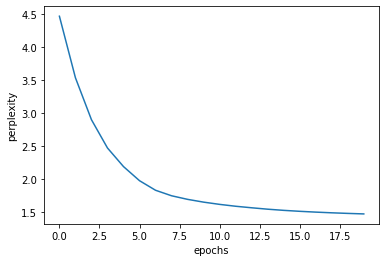

In [16]:
# train

%matplotlib inline
import sys
sys.path.append('..')
import matplotlib.pyplot as plt
import numpy as np
from common2.optimizer import SGD

x_label_num = 63
y_label_num = 5

hidden_size = 5
time_size = 3
lr = 0.001
max_epoch = 20

data_size = len(x_train)
max_iters = data_size - time_size + 1
time_idx = 0
total_loss = 0
loss_count = 0
ppl_list = []

model = RnnHand(x_label_num, y_label_num, hidden_size)
optimizer = SGD(lr)

for epoch in range(max_epoch):
    for iter in range(max_iters):
        batch_x = np.empty((1, time_size, x_label_num), dtype='f')
        batch_t = np.empty((1, time_size, y_label_num), dtype='f')
        for t in range(time_size):
            for i in range(x_label_num):
                batch_x[0, t, i] = x_train_numpy[iter + t, i]
            for i in range(y_label_num):
                batch_t[0, t, i] = y_train_numpy[iter + t, i]
        loss = model.forward(batch_x, batch_t)
        model.backward()
        optimizer.update(model.params, model.grads)
        total_loss += loss
        loss_count += 1

    # 에폭마다 퍼플렉서티 평가
    ppl = np.exp(total_loss / loss_count)
    print('| 에폭 %d | 퍼플렉서티 %.2f'
          % (epoch+1, ppl))
    ppl_list.append(float(ppl))
    total_loss, loss_count = 0, 0
 
# 그래프 그리기
x = np.arange(len(ppl_list))
plt.plot(x, ppl_list, label='train')
plt.xlabel('epochs')
plt.ylabel('perplexity')
plt.show()


RNN score:  0.6659142212189616


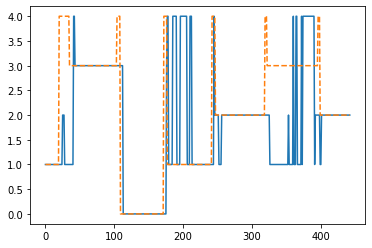

In [17]:
# test

data_size = len(x_test_numpy)
max_iters = data_size - time_size + 1

score = 0

predict_list = []
answer_list = []

for iter in range(max_iters):
    batch_x = np.empty((1, time_size, x_label_num), dtype='f')
    batch_t = np.empty((1, time_size, y_label_num), dtype='f')
    for t in range(time_size):
        for i in range(x_label_num):
            batch_x[0, t, i] = x_test_numpy[iter + t, i]
        for i in range(y_label_num):
            batch_t[0, t, i] = y_test_numpy[iter + t, i]
    add_score, predict, answer = model.check(batch_x, batch_t)
    score += add_score
    predict_list.append(predict)
    answer_list.append(answer)

print("RNN score: ", score / max_iters)

x = range(len(predict_list))
plt.plot(predict_list)
plt.plot(answer_list, '--')

scaled RNN score:  0.6997742663656885


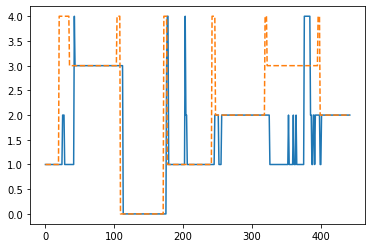

In [20]:
# test_scaled

data_size = len(x_test_numpy)
max_iters = data_size - time_size + 1

score = 0

predict_list = []
answer_list = []

for iter in range(max_iters):
    batch_x = np.empty((1, time_size, x_label_num), dtype='f')
    batch_t = np.empty((1, time_size, y_label_num), dtype='f')
    for t in range(time_size):
        for i in range(x_label_num):
            batch_x[0, t, i] = x_test_numpy[iter + t, i]
        for i in range(y_label_num):
            batch_t[0, t, i] = y_test_numpy[iter + t, i]
    add_score, predict, answer = model.check(batch_x, batch_t, 2)
    score += add_score
    predict_list.append(predict)
    answer_list.append(answer)

print("scaled RNN score: ", score / max_iters)

x = range(len(predict_list))
plt.plot(predict_list)
plt.plot(answer_list, '--')